In [ ]:
pip install numpy==1.26.0

In [ ]:
import numpy as np

print(np.__version__)

In [ ]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
)
from monai.visualize import plot_2d_or_3d_image

In [ ]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

device

In [ ]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

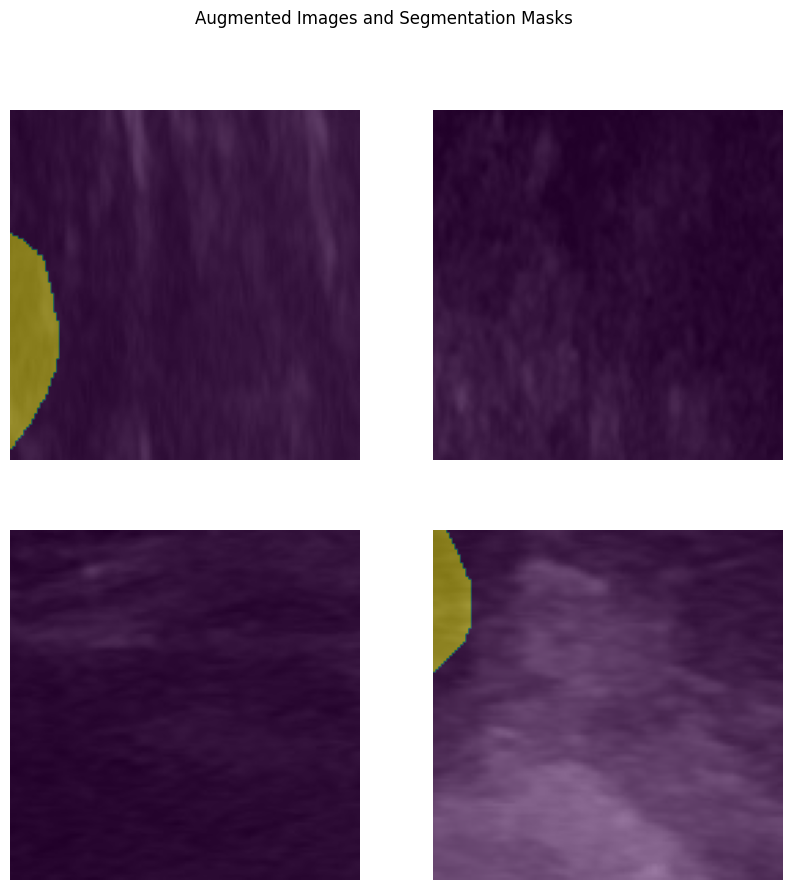

In [10]:
import os
import glob
import matplotlib.pyplot as plt
import monai
from monai.transforms import Compose, LoadImage, ScaleIntensity, RandSpatialCrop, RandRotate90
from monai.data import ArrayDataset, DataLoader
from monai.metrics import DiceMetric, MeanIoU, ConfusionMatrixMetric
from monai.transforms import Activations, AsDiscrete
from torch.utils.tensorboard import SummaryWriter
import torch

tempdir = "/Users/nittin_murthi/Documents/VS_Code/MONAI-UNET/segmentation_data/malignant/"

# Define paths to image and mask directories
image_dir = os.path.join(tempdir, "image")
mask_dir = os.path.join(tempdir, "mask")

# Read image and mask file paths
images = sorted(glob.glob(os.path.join(image_dir, "*.png")))
masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

if len(images) != len(masks):
    raise ValueError("The number of images and masks must be the same.")

# Print the total number of samples in the dataset
total_samples = len(images)
print(f"Total number of samples in the dataset: {total_samples}")

# Verify that images and masks are correctly matched
for img_path, mask_path in zip(images, masks):
    img_name = os.path.basename(img_path).split('.')[0].replace(" ", "")
    mask_name = os.path.basename(mask_path).split('.')[0].replace("_mask_merged", "").replace(" ", "")
    if img_name != mask_name:
        raise ValueError(f"Image and mask names do not match: {img_name} vs {mask_name}")
    
# Define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((128, 128), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)
train_masktrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((128, 128), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)
val_imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
val_masktrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])

# Define array dataset, data loader
check_ds = ArrayDataset(images, train_imtrans, masks, train_masktrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=True)
im, msk = monai.utils.misc.first(check_loader)
print(im.shape, msk.shape)

# Display some raw images and their corresponding segmentation masks
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        axes[i, j].imshow(im[idx].permute(1, 2, 0).cpu().numpy())
        axes[i, j].imshow(msk[idx].squeeze().cpu().numpy(), alpha=0.5)
        axes[i, j].axis('off')
plt.suptitle("Raw Images and Segmentation Masks")
plt.show()

# Split the dataset into training and validation sets
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_images, val_images = images[:train_size], images[train_size:]
train_masks, val_masks = masks[:train_size], masks[train_size:]

# Create a training data loader
train_ds = ArrayDataset(train_images, train_imtrans, train_masks, train_masktrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.backends.mps.is_available())

# Create a validation data loader
val_ds = ArrayDataset(val_images, val_imtrans, val_masks, val_masktrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

# Display some augmented images and their corresponding segmentation masks
aug_images, aug_masks = next(iter(train_loader))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        axes[i, j].imshow(aug_images[idx].permute(1, 2, 0).cpu().numpy())
        axes[i, j].imshow(aug_masks[idx].squeeze().cpu().numpy(), alpha=0.5)
        axes[i, j].axis('off')
plt.suptitle("Augmented Images and Segmentation Masks")
plt.show()

In [11]:
# Define the model, loss, and optimizer
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# Define metrics
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
mean_iou_metric = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)
precision_metric = ConfusionMatrixMetric(include_background=True, metric_name="precision")
recall_metric = ConfusionMatrixMetric(include_background=True, metric_name="recall")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
writer = SummaryWriter()

for epoch in range(200):
    print("-" * 200)
    print(f"epoch {epoch + 1}/200")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (128, 128)
                sw_batch_size = 4
                val_outputs = monai.inferers.sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in monai.data.decollate_batch(val_outputs)]
                
                # Compute metrics for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                mean_iou_metric(y_pred=val_outputs, y=val_labels)
                precision_metric(y_pred=val_outputs, y=val_labels)
                recall_metric(y_pred=val_outputs, y=val_labels)
            
            # Aggregate the final mean metric results
            dice = dice_metric.aggregate().item()
            mean_iou = mean_iou_metric.aggregate().item()
            precision = precision_metric.aggregate()
            recall = recall_metric.aggregate()

            # Ensure to take the mean if it's a list
            precision = sum(precision) / len(precision)
            recall = sum(recall) / len(recall)
            
            # Reset the status for next validation round
            dice_metric.reset()
            mean_iou_metric.reset()
            precision_metric.reset()
            recall_metric.reset()
            
            metric_values['dice'].append(dice)
            metric_values['iou'].append(mean_iou)
            metric_values['precision'].append(precision)
            metric_values['recall'].append(recall)
            
            if dice > best_metric:
                best_metric = dice
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("Saved new best metric model")
            
            print(
                "Current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, dice, best_metric, best_metric_epoch
                )
            )
            print(
                "MeanIOU: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
                    mean_iou, precision, recall
                )
            )
            writer.add_scalar("val_mean_dice", dice, epoch + 1)
            writer.add_scalar("val_mean_iou", mean_iou, epoch + 1)
            writer.add_scalar("val_precision", precision, epoch + 1)
            writer.add_scalar("val_recall", recall, epoch + 1)
            
            # Plot the last model output as GIF image in TensorBoard with the corresponding image and label
            monai.visualize.plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
            monai.visualize.plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            monai.visualize.plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 1/200
1/42, train_loss: 0.8202
2/42, train_loss: 0.5650
3/42, train_loss: 0.8059
4/42, train_loss: 1.0000
5/42, train_loss: 0.6489
6/42, train_loss: 0.8058
7/42, train_loss: 0.6121
8/42, train_loss: 0.5661
9/42, train_loss: 0.7286
10/42, train_loss: 0.5152
11/42, train_loss: 0.6208
12/42, train_loss: 0.6089
13/42, train_loss: 0.8013
14/42, train_loss: 0.7766
15/42, train_loss: 0.5596
16/42, train_loss: 0.6307
17/42, train_loss: 0.5854
18/42, train_loss: 0.8270
19/42, train_loss: 0.7589
20/42, train_loss: 0.5063
21/42, train_loss: 0.7350
22/42, train_loss: 0.8145
23/42, train_loss: 0.8480
24/42, train_loss: 0.3466
25/42, train_loss: 0.9289
26/42, train_loss: 0.8757
27/42, train_loss: 0.5355
28/42, train_loss: 0.6766
29/42, train_loss: 1.0000
30/42, train_loss: 0.8201
31/42, train_los

AttributeError: 'list' object has no attribute 'item'